<a href="https://colab.research.google.com/github/bchada/.github/blob/main/PredictKAM_Lab_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predict Peak Knee Adduction Moment (KAM) from Marker Positions: In-Class Lab

> Running Inverse kinematics and dynamics can require large computations and time. What if we instead train a machine learning model to take key points (or marker positions) and directly compute KAM?

In this lab you'll:
1. **Explore the dataset** (marker trajectories and peak KAM).
2. Learn to make DataLoaders and training loops
3. Build and train a **simple linear layer** from flattened marker positions to peak KAM.
4. Build a **Multilayer Perceptron (MLP)** and  **Long Short-term Memory (LSTM)**.
6. Mix and match to try to outperform a linear regression!

Data descriptions and original pipeline (keras) are in the project README and paper (see course site). This lab is adapted for educational purposes.


In [1]:
# !pip -q install numpy torch torchvision torchaudio scikit-learn matplotlib

import os, sys, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl

# Colab display defaults
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
mpl.rcParams['animation.html'] = 'jshtml'

# Reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

g = torch.Generator().manual_seed(42)
set_seed(42)

print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


Torch: 2.8.0+cu126 | CUDA available: False


In [2]:
from google.colab import drive
import zipfile, os

drive.mount('/content/drive', force_remount=True)

# Change this to your repo/folder containing utils.py
PROJECT_DIR = "/content/drive/MyDrive/Simulations_ML_Lab"
assert os.path.exists(os.path.join(PROJECT_DIR, "utils.py")), "utils.py not found at PROJECT_DIR"

# Add to Python path so "from utils import ..." works
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

from utils import scatter_pred_vs_true, show_marker_positions, PlotTrainingCurves, sample_indices_per_subject

zip_path = os.path.join(PROJECT_DIR, "inputData.zip")
extract_path = os.path.join(PROJECT_DIR, "Data")
data_file = os.path.join(extract_path, "inputData.npy")

# Make sure the target folder exists
os.makedirs(extract_path, exist_ok=True)

# Only extract if inputData.npy not already there
if not os.path.exists(data_file):
    print("inputData.npy not found — extracting archive...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("inputData.npy already exists, skipping extraction.")

# List contents for verification
print("Contents of Data folder:", os.listdir(extract_path))



Mounted at /content/drive
inputData.npy not found — extracting archive...
Extraction complete.
Contents of Data folder: ['inputData.npy', 'subjectSplit.npy']



## 1) Load & Explore the Data

The dataset provides **marker trajectories** (13 markers (x, y, z) × 30 timesteps per step), **KAM** during stance, and other metadata (described in README).  
First lets load and explore the dataset.


In [16]:
# Load input data dictionary
DATA_FILE = os.path.join(PROJECT_DIR, "Data/inputData.npy")
inputData = np.load(DATA_FILE, allow_pickle=True).flat[0]

# Marker Positions
markerPos = inputData['markers']

# Height (per step)
height = inputData['height']

# Weight (per step)
weight = inputData['weight']

# Leg (per step)
leg = inputData['leg']

# Subject Number (per step)
subind = inputData['subjectStepInds']

# First Knee Adduction Moment Peak (per step)
KAM = inputData['KAM']


# Visualizing the marker data
participant = 3 # try 0-85
show_marker_positions(inputData, participant=participant, frame_idx=5) # frame_idx options are 0-29

We should normalize marker positions by height and KAM by BW*h to reduce inter-subject size effects.

When training your models, see if you can reduce the number of inputs (features) before training.
1. Since we are only concerned with the first half of stance, extract the peak KAM up to frame 15 as our target.
2. Then we only need the frames 0-15 of marker positions.
3. We can also downsample the first half, so we only have 8 timepoints for each marker.
4. During training, the model has to learn both right and left leg stance, so lets help it out by including a leg index.

Input shape is (112730, 7, 40)
Output shape is (112730, 1, 1)


Text(0.5, 0, 'Step')

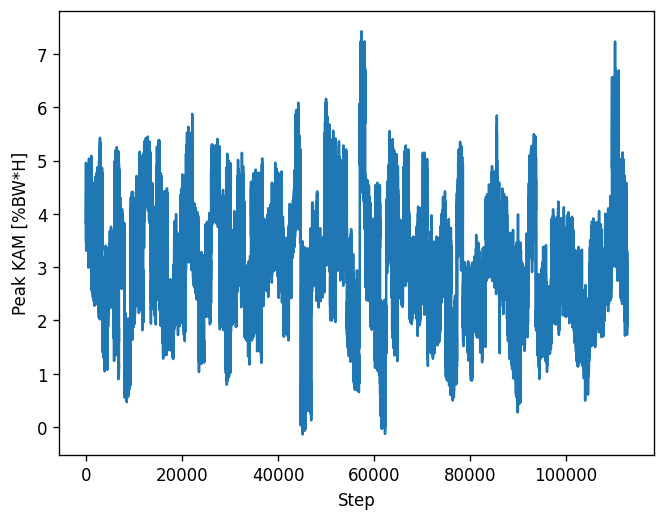

In [20]:
# Adjust input to correct format
markers = np.moveaxis(markerPos, [0,1,2], [2,1,0]) # nSamples x nTimesteps x nFeatures
weightMat = np.expand_dims(weight,axis=2)
heightMat = np.expand_dims(height,axis=2)
legBin = np.expand_dims(leg,axis=2)

# Normalize positions by height
markersNorm = np.divide(markers, heightMat)
inputMat = np.concatenate((markersNorm, legBin),axis = 2) # add leg to markers

# Use positions from first half of stance only, downsampled to 8 timepoints
firstHalfStance = range(0,16,2)

# nSamples x nTimesteps x nFeatures
inputMat = inputMat[:,firstHalfStance,:] # [all of, firstHalfStance, all of]
print("Input shape is " + str(inputMat.shape))

# Reshape the output
KAMreshape = KAM.reshape((-1,30,1))

# Normalize KAM data by height and weight (gives units of BW*H)
KAMnorm = np.divide(KAMreshape,np.multiply(weightMat.reshape(-1,30,1),heightMat.reshape(-1,30,1))) * 100

# Find peak KAM
KAMP1 = np.max(KAMnorm[:,range(15),:],axis=1)
output = KAMP1.reshape((-1,1,1))
print("Output shape is " + str(output.shape))

plt.plot(output[:,0,0])
plt.ylabel("Peak KAM [%BW*H]")
plt.xlabel("Step")

> The subject split should be done prior to training/evaluating to avoid data leakage

We will use the original paper's subject split, which is given in "subjectSplit.npy", so everyone in the class can compare results.

In [10]:
# Load paper's subject split
SUB_SPLIT_PATH = os.path.join(PROJECT_DIR, "Data/subjectSplit.npy")
subFile = np.load(SUB_SPLIT_PATH, allow_pickle=True)
subSplit = subFile.flat[0]
# TODO: collect train, dev, and testNums
trainNums = subSplit['trainNums']
devNums = subSplit['devNums']
testNums = subSplit['testNums']


# THIS IS FOR ALL STEPS
# # Find step indicies for each subject in each set
# trainInds = np.array(0)
# for i in trainNums:
#     trainInds = np.append(trainInds,np.argwhere(subind==i))
# trainInds = trainInds[1:]
#
# devInds = np.array(0)
# for i in devNums:
#     devInds = np.append(devInds,np.argwhere(subind==i))
# devInds = devInds[1:]
#
# testInds = np.array(0)
# for i in testNums:
#     testInds = np.append(testInds,np.argwhere(subind==i))
# testInds = testInds[1:]

# THIS IS TO REDUCE THE NUMBER OF SAMPLES
MAX_STEPS_PER_SUBJECT = 500 # decrease if you're computer is running slowly. Use all subjects for real modeling.
trainInds = sample_indices_per_subject(subind, trainNums, MAX_STEPS_PER_SUBJECT, seed=42)
devInds   = sample_indices_per_subject(subind, devNums,   MAX_STEPS_PER_SUBJECT, seed=42)
testInds  = sample_indices_per_subject(subind, testNums,  MAX_STEPS_PER_SUBJECT, seed=42)


# Build training, development, and test inputs and labels
trainInput_full = inputMat[trainInds]
trainInput_full = trainInput_full.reshape((trainInput_full.shape[0],-1))
trainLabels = output[trainInds,0]
print("Training shape: " + str(trainInput_full.shape))

devInput_full = inputMat[devInds]
devInput_full = devInput_full.reshape((devInput_full.shape[0],-1))
devLabels = output[devInds,0]
print("Dev shape: " + str(devInput_full.shape))

testInput_full = inputMat[testInds]
testInput_full = testInput_full.reshape((testInput_full.shape[0],-1))
testLabels = output[testInds,0]
print("Test shape: " + str(testInput_full.shape))

Training shape: (35000, 320)
Dev shape: (4000, 320)
Test shape: (4000, 320)


> There are additional ways of reducing the features in a model prior to training, such as LASSO.

This is a statistical technique to remove the features which have the smallest impact on the outcome measures.
LASSO was already performed and the indicies are given in "lassoDeletedInds3D".

How many features did this remove?

In [12]:
lassoDeletedInds = inputData['lassoDeletedInds3D'] #find features that are most important.
inputIndicies = np.delete(np.arange(0,320),np.unique(np.concatenate((np.arange(79,320,40),lassoDeletedInds)))) # only keep the most important features. Makes training go faster.

# TODO: keep the inputIndicies for each train, dev, and test input
trainInput = trainInput_full[:, inputIndicies]
devInput = devInput_full[:, inputIndicies]
testInput = testInput_full[:, inputIndicies]


print("After LASSO: " + str(trainInput.shape))

After LASSO: (35000, 299)


> One of the simplest relationships would be a linear regression from input features to output KAM.

[LinearRegression] Train  R^2: 0.775  |  MAE: 0.368
[LinearRegression] Dev    R^2: 0.492  |  MAE: 0.617


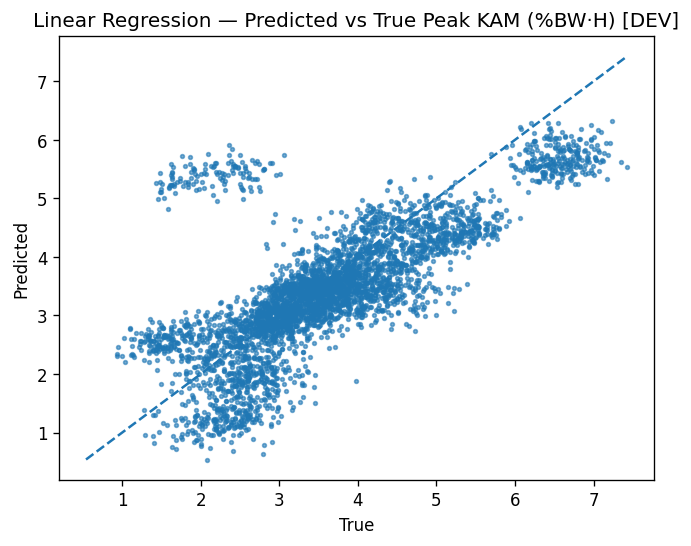

In [14]:
from sklearn.linear_model import LinearRegression

# Fit on TRAIN
linreg = LinearRegression()
linreg.fit(trainInput, np.ravel(trainLabels))  # y must be 1D

# Predict training and dev KAM
train_pred = linreg.predict(trainInput)
dev_pred = linreg.predict(devInput)

# View performance of the training set
train_mae = mean_absolute_error(np.ravel(trainLabels), train_pred)
train_r2  = r2_score(np.ravel(trainLabels), train_pred)
print(f"[LinearRegression] Train  R^2: {train_r2:.3f}  |  MAE: {train_mae:.3f}")

# View performance of the dev set
dev_mae = mean_absolute_error(np.ravel(devLabels), dev_pred)
dev_r2  = r2_score(np.ravel(devLabels), dev_pred)
print(f"[LinearRegression] Dev    R^2: {dev_r2:.3f}  |  MAE: {dev_mae:.3f}")

# Do NOT evaluate on the test set until you have chosen a final model!

# Scatter plot (Predicted vs True on DEV)
scatter_pred_vs_true(
    y_true=np.ravel(devLabels),
    y_pred=dev_pred,
    title="Linear Regression — Predicted vs True Peak KAM (%BW·H) [DEV]"
)